In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from pickle import dump as save
from pickle import load as download

In [ ]:
def decoder_npy(path):
    data = np.load(path, allow_pickle=True)
    d = dict(enumerate(data.flatten(), 1))
    
    return d[1]

# Делаем вектора для early-fusion

In [ ]:
train_video = decoder_npy('/kaggle/input/pooling/train_video_embs.npy')
test_video = decoder_npy('/kaggle/input/pooling/test_video_embs.npy')
dev_video = decoder_npy('/kaggle/input/pooling/dev_video_embs.npy')

train_text = decoder_npy('/kaggle/input/pooling/train_text_emb_768.npy')
test_text = decoder_npy('/kaggle/input/pooling/test_text_emb_768.npy')
dev_text = decoder_npy('/kaggle/input/pooling/dev_text_emb_768.npy')

In [ ]:
def make_text_set(text):
    new_dict = {}

    for i in text.keys():
        new_name = i.split('_')[0][3:] + '_' +  i.split('_')[1][3:]
        new_dict[new_name] = text[i]
        
    return new_dict

In [ ]:
train_text = make_text_set(train_text)
test_text = make_text_set(test_text)
dev_text = make_text_set(dev_text)

In [ ]:
def make_video_set(video, for_target):
    new_dict = {}

    for i in video.keys():
        new_dict[video[i]['name']] = {'emb': video[i]['vector'],
                                      'target': for_target[video[i]['name']]['target']}
        
        
    return new_dict

In [ ]:
train_video = make_video_set(train_video, train_text)
dev_video = make_video_set(dev_video, dev_text)
test_video = make_video_set(test_video, test_text)

In [ ]:
train_audio = pd.read_csv('/kaggle/input/pooling/train_openSMILE.csv', header=0, index_col='file', sep=',')
test_audio = pd.read_csv('/kaggle/input/pooling/test_openSMILE.csv', header=0, index_col='file', sep=',')
dev_audio = pd.read_csv('/kaggle/input/pooling/dev_openSMILE.csv', header=0, index_col='file', sep=',')

In [ ]:
def make_audio_set(audio):
    vector = audio.drop(['target'], axis=1)
    y = audio['target']
    
    new_dict = {}
    for i in audio.index:
        list_vector = np.array(np.float_(vector.loc[i].values.flatten().tolist()))
        target = y[i]
        
        new_name = i.split('_')[0][3:] + '_' + i.split('_')[1][3:][:-4]
        new_dict[new_name] = {'emb': list_vector, 'target': target}
        
    return new_dict

In [ ]:
train_audio = make_audio_set(train_audio)
dev_audio = make_audio_set(dev_audio)
test_audio = make_audio_set(test_audio)

In [ ]:
def make_working_set(data, targets):
    out = []
    y = []

    for i in data.keys():
        out.append(data[i]['emb'])
        y.append(data[i]['target'])

    y = np.array(y)

    for i in targets.keys():
        y[y == i] = targets[i]

    return np.array(out), y.astype('int')

In [ ]:
dict_tar = {'anger': 0, 'disgust': 1, 'fear': 2, 'sadness': 3, 'neutral': 4, 
            'joy': 5, 'surprise': 6}

In [ ]:
def get_scaler_pca(inp_set, type_set, dict_tar):
    X_train, y_train = make_working_set(inp_set, dict_tar)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)

    n = 512
    pca = PCA(n_components=n, random_state=123)
    pca.fit(X_train)

    print(f'Потеря информации для {type_set}: {1 - sum(pca.explained_variance_ratio_)}')
    
    f = open(f'PCA_{type_set}.pickle', 'wb')
    save(pca, f)
    f.close()

    f = open(f'scaler_{type_set}.pickle', 'wb')
    save(scaler, f)
    f.close()
    
    return

In [ ]:
get_scaler_pca(train_audio, 'audio', dict_tar)

Потеря информации для audio: 0.16333748701620077


In [ ]:
get_scaler_pca(train_text, 'text', dict_tar)

Потеря информации для text: 0.00247920461647011


In [ ]:
X_train, y_train = make_working_set(train_text, dict_tar)

scaler = StandardScaler()
scaler.fit(X_train)
    
f = open(f'scaler_text.pickle', 'wb')
save(scaler, f)
f.close()

In [ ]:
X_train, y_train = make_working_set(train_video, dict_tar)

scaler = StandardScaler()
scaler.fit(X_train)
    
f = open(f'scaler_video.pickle', 'wb')
save(scaler, f)
f.close()

In [ ]:
f = open('/kaggle/working/scaler_audio.pickle', 'rb')
scaler_audio = download(f)
f.close

f = open('/kaggle/working/PCA_audio.pickle', 'rb')
pca_audio = download(f)
f.close

f = open('/kaggle/working/scaler_text.pickle', 'rb')
scaler_text = download(f)
f.close

f = open('/kaggle/working/PCA_text.pickle', 'rb')
pca_text = download(f)
f.close

f = open('/kaggle/working/scaler_video.pickle', 'rb')
scaler_video = download(f)
f.close

<function BufferedReader.close>

In [ ]:
def make_common_vector_ss(text, audio, video, filename, pca_text, pca_audio, 
                         ascaler, vscaler, tscaler):
    new_dict = {}
    
    for i in video.keys():
        audio_row = ascaler.transform(audio[i]['emb'].reshape(-1, 1).T)
        video_row = vscaler.transform(np.array(video[i]['emb']).reshape(-1, 1).T).tolist()[0]
        text_row = tscaler.transform(text[i]['emb'].reshape(-1, 1).T)
        
        audio_row = pca_audio.transform(audio_row).tolist()[0]
        text_row = pca_text.transform(text_row).tolist()[0]
        
        new_vector = text_row + audio_row + video_row
        
        new_dict[i] = {'emb': new_vector, 'target': audio[i]['target']}
        
    np.save(filename, new_dict)
    return new_dict

In [ ]:
train_vector_ss = make_common_vector_ss(train_text, train_audio, train_video, 
                                     'train_ss_trained_pooler', pca_audio, scaler_audio,
                                     scaler_video, scaler_text)
test_vector_ss = make_common_vector_ss(test_text, test_audio, test_video, 
                                    'test_ss_trained_pooler', pca_audio, scaler_audio,
                                     scaler_video, scaler_text)
dev_vector_ss = make_common_vector_ss(dev_text, dev_audio, dev_video, 
                                   'dev_ss_trained_pooler', pca_audio, scaler_audio,
                                    scaler_video, scaler_text)

# Строим модели и сохраняем эксперименты

In [ ]:
import sklearn.svm

In [ ]:
def statistic(y_pred_test, y_test, y_pred_train, y_train):
    score_table = pd.DataFrame(columns=('train', 'test'))

    b_train = balanced_accuracy_score(y_train, y_pred_train)
    b_test = balanced_accuracy_score(y_test, y_pred_test)
    score_table.loc['balanced_accuracy_score', :] = (b_train, b_test)

    a_train = accuracy_score(y_train, y_pred_train)
    a_test = accuracy_score(y_test, y_pred_test)
    score_table.loc['accuracy_score', :] = (a_train, a_test)

    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    score_table.loc['f1 weighted', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='micro')
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    score_table.loc['f1 micro', :] = (f1_train, f1_test)

    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    score_table.loc['f1 macro', :] = (f1_train, f1_test)

    return score_table

In [ ]:
def cm_plot(y_test, y_pred, y_type):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title(f'Confusion Matrix of {y_type}')

    return plt.show()

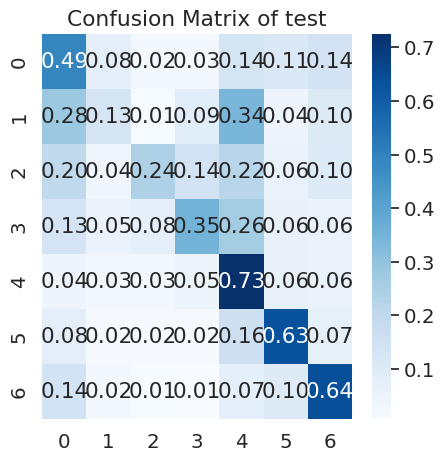

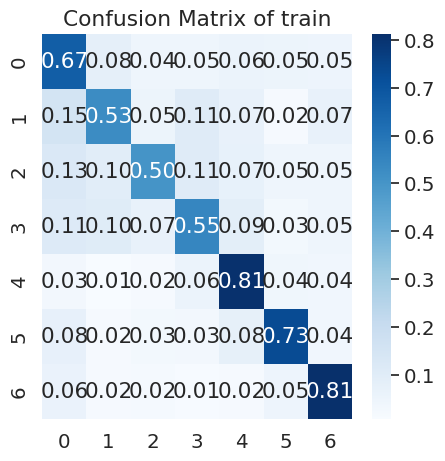

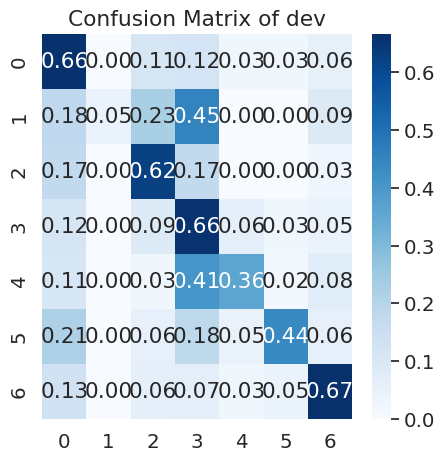

              precision    recall  f1-score   support

           0       0.48      0.49      0.48       345
           1       0.09      0.13      0.11        68
           2       0.14      0.24      0.18        50
           3       0.44      0.35      0.39       208
           4       0.80      0.73      0.76      1256
           5       0.61      0.63      0.62       402
           6       0.51      0.64      0.57       281

    accuracy                           0.62      2610
   macro avg       0.44      0.46      0.44      2610
weighted avg       0.64      0.62      0.63      2610



,train,test
balanced_accuracy_score,0.65685,0.459055
accuracy_score,0.744435,0.616475
f1 weighted,0.755048,0.625021
f1 micro,0.744435,0.616475
f1 macro,0.618545,0.4442


In [ ]:
from sklearn import metrics #text embs dim was 512, audio 6373, video 512 (common vector 1536)
classifier = sklearn.svm.SVC(C=1, random_state=3, class_weight='balanced')

classifier.fit(X_train2, y_train2)#dev + train

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train2)
y_train_dev = classifier.predict(X_dev)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train2, y_train_pred, 'train')
cm_plot(y_dev, y_train_dev, 'dev')

print(metrics.classification_report(y_test, y_pred))

statistic(y_pred, y_test, y_train_pred, y_train2)

In [ ]:
from pickle import dump as _save_

f = open('SVC_model_61_64score_pooler_512.pickle', 'wb')
_save_(classifier, f)
f.close()

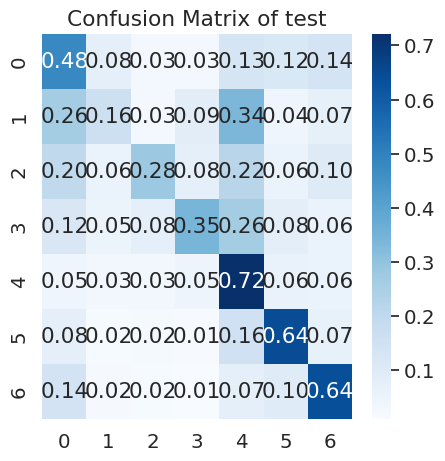

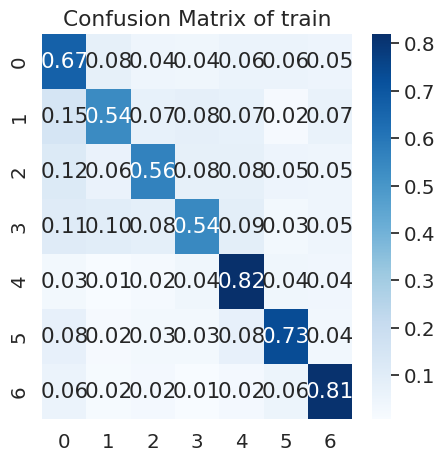

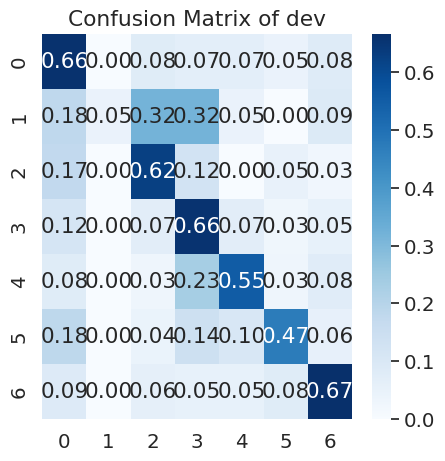

              precision    recall  f1-score   support

           0       0.48      0.48      0.48       345
           1       0.10      0.16      0.13        68
           2       0.14      0.28      0.19        50
           3       0.45      0.35      0.39       208
           4       0.81      0.72      0.76      1256
           5       0.61      0.64      0.62       402
           6       0.52      0.64      0.57       281

    accuracy                           0.62      2610
   macro avg       0.44      0.47      0.45      2610
weighted avg       0.64      0.62      0.63      2610



,train,test
balanced_accuracy_score,0.667671,0.467386
accuracy_score,0.752095,0.615709
f1 weighted,0.761351,0.625343
f1 micro,0.752095,0.615709
f1 macro,0.62858,0.44897


In [ ]:
from sklearn import metrics #text embs dim was 768, audio 6373, video 512 (common vector 1536)
classifier = sklearn.svm.SVC(C=1, random_state=3, class_weight='balanced')

classifier.fit(X_train2, y_train2)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train2)
y_train_dev = classifier.predict(X_dev)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train2, y_train_pred, 'train')
cm_plot(y_dev, y_train_dev, 'dev')

print(metrics.classification_report(y_test, y_pred))

statistic(y_pred, y_test, y_train_pred, y_train2)

In [ ]:
from pickle import dump as _save_

f = open('SVC_model_61_57score_pooler_768.pickle', 'wb')
_save_(classifier, f)
f.close()

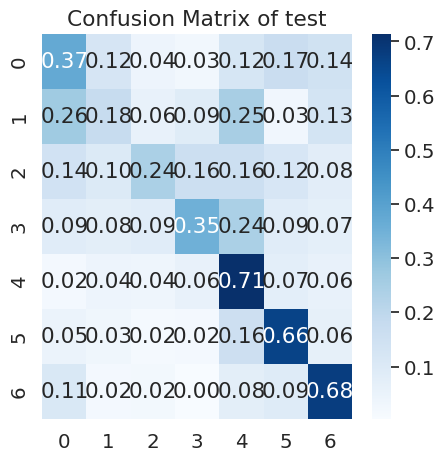

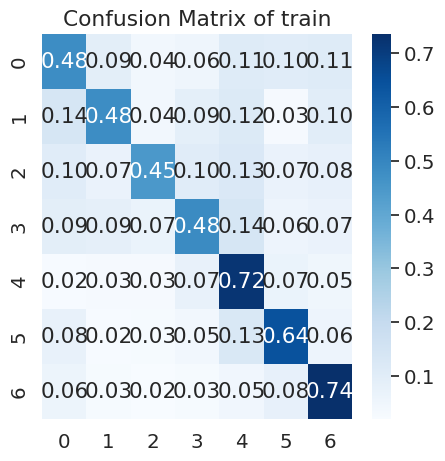

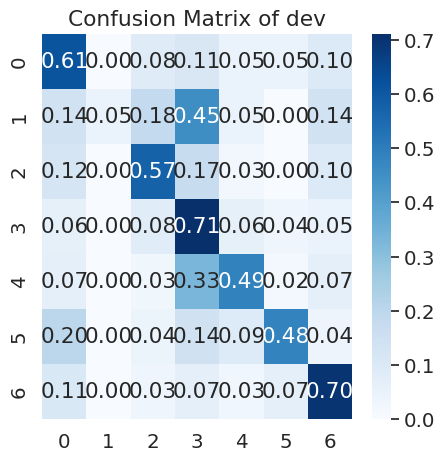

              precision    recall  f1-score   support

           0       0.53      0.37      0.44       345
           1       0.08      0.18      0.11        68
           2       0.11      0.24      0.15        50
           3       0.41      0.35      0.38       208
           4       0.82      0.71      0.76      1256
           5       0.57      0.66      0.61       402
           6       0.52      0.68      0.59       281

    accuracy                           0.60      2610
   macro avg       0.43      0.46      0.43      2610
weighted avg       0.64      0.60      0.62      2610



,train,test
balanced_accuracy_score,0.570517,0.456195
accuracy_score,0.650626,0.604981
f1 weighted,0.663842,0.617831
f1 micro,0.650626,0.604981
f1 macro,0.527387,0.434389


In [ ]:
from sklearn import metrics #text embs dim was 768 with trained roberta with hidden_output, audio 6373, video 512 (common vector 1536)
classifier = sklearn.svm.SVC(C=1, random_state=3, class_weight='balanced')

classifier.fit(X_train2, y_train2)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train2)
y_train_dev = classifier.predict(X_dev)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train2, y_train_pred, 'train')
cm_plot(y_dev, y_train_dev, 'dev')

print(metrics.classification_report(y_test, y_pred))

statistic(y_pred, y_test, y_train_pred, y_train2)

In [ ]:
from pickle import dump as _save_

f = open('SVC_model_60_5score_trained.pickle', 'wb')
_save_(classifier, f)
f.close()

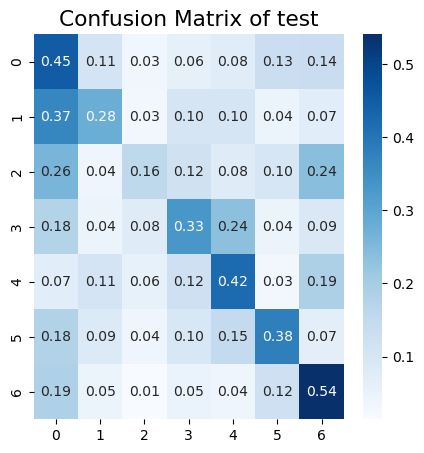

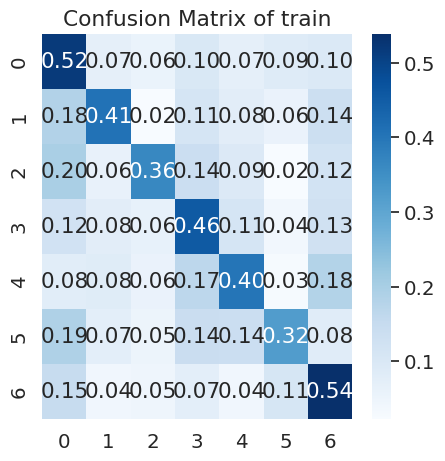

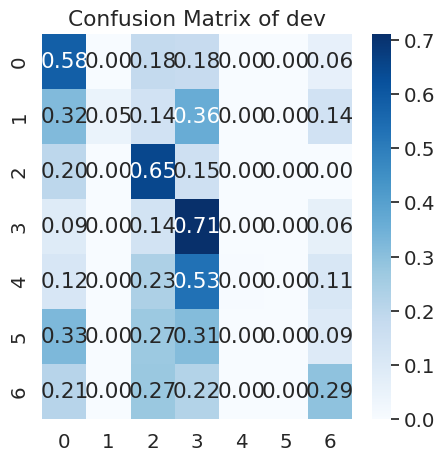

              precision    recall  f1-score   support

           0       0.35      0.45      0.39       345
           1       0.08      0.28      0.12        68
           2       0.06      0.16      0.09        50
           3       0.22      0.33      0.27       208
           4       0.77      0.42      0.55      1256
           5       0.53      0.38      0.44       402
           6       0.30      0.54      0.39       281

    accuracy                           0.42      2610
   macro avg       0.33      0.37      0.32      2610
weighted avg       0.55      0.42      0.45      2610



,train,test
balanced_accuracy_score,0.429342,0.366688
accuracy_score,0.420564,0.416475
f1 weighted,0.449447,0.451011
f1 micro,0.420564,0.416475
f1 macro,0.354502,0.321178


In [ ]:
from sklearn import metrics
classifier = sklearn.svm.SVC(C=1, random_state=3, class_weight='balanced') #text embs dim was 768 without trained roberta,
# just pre-trained with hidden_output, audio 6373, video 512 (common vector 1536)

classifier.fit(X_train2, y_train2)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train2)
y_train_dev = classifier.predict(X_dev)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train2, y_train_pred, 'train')
cm_plot(y_dev, y_train_dev, 'dev')

print(metrics.classification_report(y_test, y_pred))

statistic(y_pred, y_test, y_train_pred, y_train2)

In [ ]:
def objective(trial):
    global X_train2, y_train2

    c = trial.suggest_float("svc_c", 1e-1, 1e2, log=True)

    clf = sklearn.svm.SVC(C=c, random_state=3, class_weight='balanced')

    score = sklearn.model_selection.cross_val_score(clf, X_train2, y_train2, cv=3, scoring='f1_macro')
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print(study.best_trial)

[I 2023-03-18 06:58:06,804] A new study created in memory with name: no-name-7cb19c46-b9eb-46b5-82ad-e818d2efd08e
[I 2023-03-18 07:05:29,675] Trial 0 finished with value: 0.31949198198773593 and parameters: {'svc_c': 24.074324035353484}. Best is trial 0 with value: 0.31949198198773593.
[I 2023-03-18 07:13:28,351] Trial 1 finished with value: 0.30941014049999277 and parameters: {'svc_c': 3.969786065017414}. Best is trial 0 with value: 0.31949198198773593.
[I 2023-03-18 07:20:44,978] Trial 2 finished with value: 0.3174361321414079 and parameters: {'svc_c': 30.100649230291545}. Best is trial 0 with value: 0.31949198198773593.
[I 2023-03-18 07:28:32,755] Trial 3 finished with value: 0.31717738559798136 and parameters: {'svc_c': 7.529199895547443}. Best is trial 0 with value: 0.31949198198773593.
[I 2023-03-18 07:37:59,336] Trial 4 finished with value: 0.20171910423981712 and parameters: {'svc_c': 0.25652946648378994}. Best is trial 0 with value: 0.31949198198773593.
[I 2023-03-18 07:46:26,

FrozenTrial(number=22, state=TrialState.COMPLETE, values=[0.3214727855050315], datetime_start=datetime.datetime(2023, 3, 18, 9, 48, 17, 587193), datetime_complete=datetime.datetime(2023, 3, 18, 9, 55, 46, 706968), params={'svc_c': 21.50718594413561}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=100.0, log=True, low=0.1, step=None)}, trial_id=22, value=None)


In [ ]:
from sklearn import metrics
classifier = sklearn.svm.SVC(C=21.50718594413561, random_state=3, class_weight='balanced')
#text embs dim was 768 without trained roberta,
# just pre-trained with hidden_output, audio 6373, video 512 (common vector 1536)

classifier.fit(X_train2, y_train2)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train2)
y_train_dev = classifier.predict(X_dev)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train2, y_train_pred, 'train')
cm_plot(y_dev, y_train_dev, 'dev')

print(metrics.classification_report(y_test, y_pred))

statistic(y_pred, y_test, y_train_pred, y_train2) 

In [ ]:
from pickle import dump as _save_

f = open('SVC_model_audio_51_19score.pickle', 'wb')
_save_(classifier, f)
f.close()

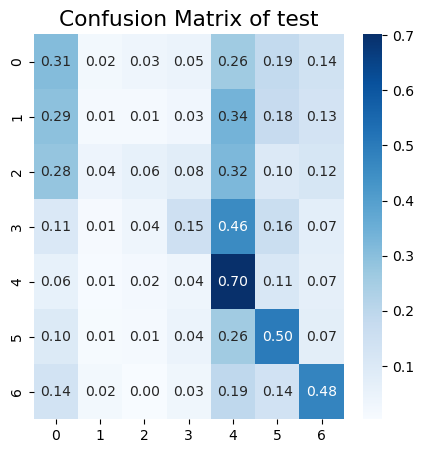

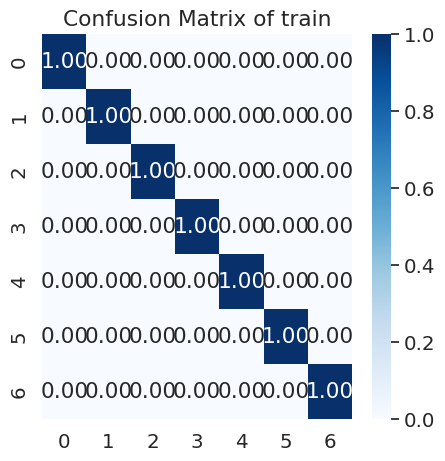

,train,test
balanced_accuracy_score,1.0,0.316027
accuracy_score,1.0,0.520307
f1 weighted,1.0,0.5123
f1 micro,1.0,0.520307
f1 macro,1.0,0.310949


In [ ]:
from sklearn.neural_network import MLPClassifier   
#text embs dim was 768 without trained roberta,
# just pre-trained with hidden_output, audio 6373, video 512 (common vector 1536)

classifier = MLPClassifier(random_state=3) 

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
y_train_pred = classifier.predict(X_train)

cm_plot(y_test, y_pred, 'test')
cm_plot(y_train, y_train_pred, 'train')

statistic(y_pred, y_test, y_train_pred, y_train)